In [1]:
import mxnet as mx
from mxnet.ndarray import linalg_gemm2 as gemm2
import mxnet.ndarray as nd

In [61]:
def ISSM_filter(z, b, F, a, g, sigma, m_prior, S_prior): 
    
    H = F.shape[0] # dim of latent state
    T = z.shape[0] # num of observations
    
    eye_h = nd.array(np.eye(H))    

    mu_seq = []
    S_seq = []
    log_p_seq = []
        
    for t in range(T):
    
        if t == 0:
            # At the first time step, use the prior
            mu_h = m_prior
            S_hh = S_prior
        else:
            # Otherwise compute using update eqns.
            F_t = F[:, :, t]            
            g_t = g[:, t].reshape((H,1))    
            
            mu_h = gemm2(F_t, mu_t)

            S_hh = gemm2(F_t, gemm2(S_t, F_t, transpose_b=1)) + \
                   gemm2(g_t, g_t, transpose_b=1)

        
        a_t = a[:, t].reshape((H,1))
        mu_v = gemm2(mu_h, a_t, transpose_a=1)

        # Compute the Kalman gain (vector)
        S_hh_x_a_t = gemm2(S_hh, a_t)
        
        sigma_t = sigma[t]
        S_vv = gemm2(a_t, S_hh_x_a_t, transpose_a=1) + nd.square(sigma_t)
        kalman_gain = nd.broadcast_div(S_hh_x_a_t, S_vv)

        # Compute the error (delta)
        delta = z[t] - b[t] - mu_v

        # Filtered estimates
        mu_t = mu_h + gemm2(kalman_gain, delta)
        
            
        # Joseph's symmetrized update for covariance:
        ImKa = nd.broadcast_sub(eye_h, gemm2(kalman_gain, a_t, transpose_b=1))
        S_t = gemm2(gemm2(ImKa, S_hh), ImKa, transpose_b=1) + \
                nd.broadcast_mul(gemm2(kalman_gain, kalman_gain, transpose_b=1), nd.square(sigma_t))
                
        # likelihood term
        log_p = (-0.5 * (delta * delta / S_vv
                         + np.log(2.0 * np.pi)
                         + nd.log(S_vv))
                 )

        mu_seq.append(mu_t)
        S_seq.append(S_t)
        log_p_seq.append(log_p)


    return mu_seq, S_seq, log_p_seq

In [56]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
import seaborn as sns

In [80]:
df = pd.read_csv("../datasets/fourweekly-totals-of-beer-shipme.csv", header=0)

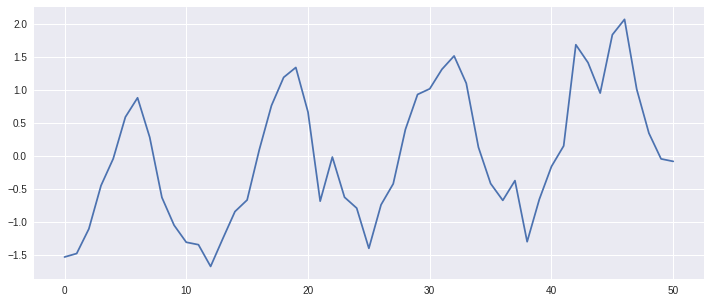

In [92]:
# get the time series 
ts = df.values[:,1]

# Let us normalize the time series
ts = np.array((ts - np.mean(ts)) / np.std(ts), dtype=np.double)

plt.plot(ts);

In [99]:
latent_dim = 1
T          = len(ts)

# Set the coefficients of the ISSM
delta      = 1.0
F          = delta * nd.ones((1, 1, T))
a          = delta * nd.ones((1, T))

# Set the parameters of the ISSM
alpha      = 0.5
g          = alpha * nd.ones((1, T))

m_prior    = nd.zeros((latent_dim, 1))
S_prior    = nd.zeros((latent_dim, latent_dim))
sigma      = 0.5 * nd.ones((T, 1))
b          = nd.zeros((T, 1))
z          = nd.array(ts).reshape((T, 1))

In [100]:
def ISSM_filter(z, b, F, a, g, sigma, m_prior, S_prior): 
    
    H = F.shape[0] # dim of latent state
    T = z.shape[0] # num of observations
    
    eye_h = nd.array(np.eye(H))    

    mu_seq = []
    S_seq = []
    log_p_seq = []
        
    for t in range(T):
    
        if t == 0:
            # At the first time step, use the prior
            mu_h = m_prior
            S_hh = S_prior
        else:
            # Otherwise compute using update eqns.
            F_t = F[:, :, t]            
            g_t = g[:, t].reshape((H,1))    
            
            mu_h = gemm2(F_t, mu_t)

            S_hh = gemm2(F_t, gemm2(S_t, F_t, transpose_b=1)) + \
                   gemm2(g_t, g_t, transpose_b=1)

        
        a_t = a[:, t].reshape((H,1))
        mu_v = gemm2(mu_h, a_t, transpose_a=1)

        # Compute the Kalman gain (vector)
        S_hh_x_a_t = gemm2(S_hh, a_t)
        
        sigma_t = sigma[t]
        S_vv = gemm2(a_t, S_hh_x_a_t, transpose_a=1) + nd.square(sigma_t)
        kalman_gain = nd.broadcast_div(S_hh_x_a_t, S_vv)

        # Compute the error (delta)
        delta = z[t] - b[t] - mu_v

        # Filtered estimates
        mu_t = mu_h + gemm2(kalman_gain, delta)
        
            
        # Joseph's symmetrized update for covariance:
        ImKa = nd.broadcast_sub(eye_h, gemm2(kalman_gain, a_t, transpose_b=1))
        S_t = gemm2(gemm2(ImKa, S_hh), ImKa, transpose_b=1) + \
                nd.broadcast_mul(gemm2(kalman_gain, kalman_gain, transpose_b=1), nd.square(sigma_t))
                
        # likelihood term
        log_p = (-0.5 * (delta * delta / S_vv
                         + np.log(2.0 * np.pi)
                         + nd.log(S_vv))
                 )

        mu_seq.append(mu_t)
        S_seq.append(S_t)
        log_p_seq.append(log_p)


    return mu_seq, S_seq, log_p_seq

In [101]:
mu_seq, S_seq, _ = ISSM_filter(z, b, F, a, g, sigma, m_prior, S_prior)

In [119]:
from functools import reduce

def reconstruct(mu_seq, S_seq):
    a_np = a.asnumpy()
    T = len(mu_seq)
    sigma_np = sigma.asnumpy()
    
    v_filtered_mean = np.array([a_np[:, t].dot(mu_t.asnumpy()) 
                                for t, mu_t in enumerate(mu_seq)]
                              ).reshape(T, )
    
    v_filtered_std = np.sqrt(np.array([a_np[:, t].dot(S_t.asnumpy()).dot(a_np[:, t]) + 
                                       np.square(sigma_np[t]) 
                                       for t, S_t in enumerate(S_seq)]).reshape((T,)))
    
    return v_filtered_mean, v_filtered_std


In [132]:
v_filtered_mean, v_filtered_std = reconstruct(mu_seq, S_seq);

In [239]:
def plot_reconstruction_forecasts(v_filtered_mean, v_filtered_std, forecasts_mean, forecasts_std):

    plt.plot(ts, color="r")
    plt.plot(v_filtered_mean, color="b")
    T = len(v_filtered_mean)
    x = np.arange(T)
    plt.fill_between(x, v_filtered_mean-v_filtered_std, 
                     v_filtered_mean+v_filtered_std, 
                     facecolor="blue", alpha=0.2)
    
    plt.plot(np.arange(T, T+len(forecasts_mean)), forecasts_mean, color="g")
    plt.fill_between(np.arange(T, T+len(forecasts_mean)), forecasts_mean-forecasts_std, 
                     forecasts_mean+forecasts_std, 
                     facecolor="green", alpha=0.2)
    
    plt.legend(["data", "reconstruction", "forecasts"]);

In [240]:
def forecast(mu_last_state, S_last_state, F, a, g, sigma, horizon):
    
    forecasts_mean = []
    forecasts_std = []
    
    mu_last_state = mu_last_state.asnumpy()
    S_last_state = S_last_state.asnumpy()
    F = F.asnumpy()
    a = a.asnumpy()
    g = g.asnumpy()
    sigma = sigma.asnumpy()
    
    for t in range(horizon):
        a_t = a[:, t]
        forecast_mean = a_t.dot(mu_last_state)[0]
        forecast_std = a_t.dot(S_last_state).dot(a_t) + np.square(sigma[t])[0]
        
        forecasts_mean.append(forecast_mean)
        forecasts_std.append(forecast_std)
                    
        mu_last_state = F[:, :, t].dot(mu_last_state)
        S_last_state = F[:, :, t].dot(S_last_state).dot(F[:, :, t].T)
        
    return np.array(forecasts_mean), np.array(forecasts_std)

In [241]:
# Let us use the same cofficients (constant over time) for the future as well
forecasts_mean, forecasts_std = forecast(mu_seq[-1], 
                                          S_seq[-1], 
                                          F, a, g, sigma, horizon=13)


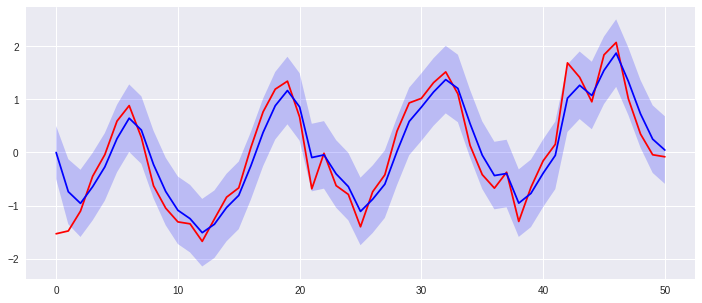

In [242]:
plt.plot(ts, color="r")
plt.plot(v_filtered_mean, color="b")
T = len(v_filtered_mean)
x = np.arange(T)
plt.fill_between(x, v_filtered_mean-v_filtered_std, 
                     v_filtered_mean+v_filtered_std, 
                     facecolor="blue", alpha=0.2)

In [249]:
latent_dim = 2
T          = len(ts)

# Set the coefficients of the ISSM
damp_fact = 1.0
damp_growth = 1.0

# Set the parameters of the ISSM
alpha      = 0.5 
beta       = 0.1 
g_t        = nd.array([alpha, beta])
g          = nd.repeat(g_t, T).reshape((latent_dim, T))

# F and a are constant over time
F_t = nd.reshape(nd.array([damp_fact, damp_growth, 0, damp_growth]), (latent_dim, latent_dim))
a_t = nd.array([damp_fact, damp_growth])
F   = nd.repeat(F_t, T).reshape((latent_dim, latent_dim, T))
a   = nd.repeat(a_t, T).reshape((latent_dim, T))

m_prior    = nd.zeros((latent_dim, 1))
S_prior    = nd.zeros((latent_dim, latent_dim))
sigma      = 0.5 * nd.ones((T, 1))
b          = nd.zeros((T, 1))
z          = nd.array(ts).reshape((T, 1))

In [250]:
mu_seq, S_seq, _ = ISSM_filter(z, b, F, a, g, sigma, m_prior, S_prior)

In [254]:
mu_seq[-1], S_seq[-1]

(
 [[ 0.08122886]
  [-0.12309923]]
 <NDArray 2x1 @cpu(0)>, 
 [[ 0.12640405  0.02245352]
  [ 0.02245352  0.00474003]]
 <NDArray 2x2 @cpu(0)>)

In [251]:
# Let us use the same cofficients (constant over time) for the future as well
forecasts_mean, forecasts_std = forecast(mu_seq[-1], 
                                          S_seq[-1], 
                                          F, a, g, sigma, horizon=13)

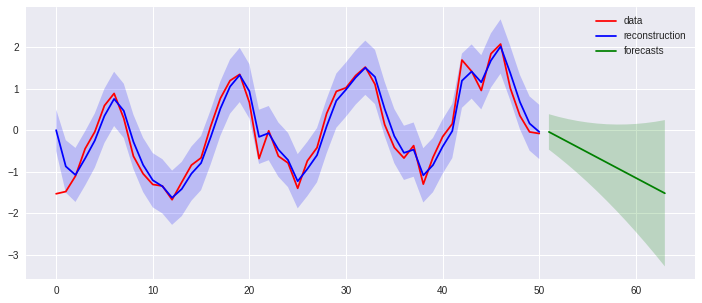

In [253]:
reconst_mean, reconst_std = reconstruct(mu_seq, S_seq)
plot_reconstruction_forecasts(reconst_mean, reconst_std, forecasts_mean, forecasts_std)